In [ ]:
!pip install graphviz

In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pickle
from sklearn.metrics import confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc,recall_score,precision_score

In [ ]:
dataset = pd.read_csv('https://raw.githubusercontent.com/jusung1459/data/main/data.txt')
dataset['date_confirmation'] = pd.to_datetime(dataset['date_confirmation'])

In [ ]:
dataset.shape

(367636, 11)

In [ ]:
dataset.dtypes

age                             int64
sex                            object
date_confirmation      datetime64[ns]
outcome                        object
combinedKey                    object
Confirmed                     float64
Deaths                        float64
Recovered                     float64
Active                        float64
Incidence_Rate                float64
Case-Fatality_Ratio           float64
dtype: object

In [ ]:
dataset

,age,sex,date_confirmation,outcome,combinedKey,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio
0,43,unknown,2020-05-26,recovered,"Delhi, India",2.388280e+05,4907.000000,201671.000000,32250.000000,1276.409575,2.054617
1,43,unknown,2020-05-20,hospitalized,"Uttar Pradesh, India",3.427880e+05,4869.000000,270094.000000,67825.000000,144.099577,1.420411
2,43,unknown,2020-05-26,hospitalized,"Maharashtra, India",1.167496e+06,31791.000000,834432.000000,301273.000000,948.072083,2.723007
3,24,female,2020-03-15,nonhospitalized,"Baden-Wurttemberg, Germany",4.677900e+04,1871.000000,41228.000000,3680.000000,422.592353,3.999658
4,43,unknown,2020-05-20,hospitalized,"Gujarat, India",1.203360e+05,3286.000000,100974.000000,16076.000000,188.400627,2.730687
...,...,...,...,...,...,...,...,...,...,...,...
367631,15,male,2020-03-31,nonhospitalized,"Santa Fe, Argentina",4.471816e+05,11778.165908,309231.802629,126171.631726,948.291557,2.873130
367632,43,unknown,2020-04-16,hospitalized,"Delhi, India",2.388280e+05,4907.000000,201671.000000,32250.000000,1276.409575,2.054617
367633,43,unknown,2020-05-30,hospitalized,"Maharashtra, India",1.167496e+06,31791.000000,834432.000000,301273.000000,948.072083,2.723007
367634,28,female,2020-03-02,recovered,Singapore,5.755800e+04,27.000000,57142.000000,389.000000,983.839751,0.046909


# 2.1 Splitting Dataset

In [ ]:
train, validation = train_test_split(dataset, test_size = 0.20, random_state = 42)

In [ ]:
x_train = train[['age', 'sex', 'date_confirmation', 'combinedKey', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incidence_Rate', 'Case-Fatality_Ratio']]
y_train = train[['outcome']]

x_validation = validation[['age', 'sex', 'date_confirmation', 'combinedKey', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incidence_Rate', 'Case-Fatality_Ratio']]
y_validation = validation[['outcome']]

In [ ]:
# encoder (categorical to numerical)
ord_enc = OrdinalEncoder()
encoded_dataSet = dataset.copy()
encoded_dataSet["sex"] = ord_enc.fit_transform(encoded_dataSet[["sex"]])
encoded_dataSet["outcome"] = ord_enc.fit_transform(encoded_dataSet[["outcome"]])
encoded_dataSet["combinedKey"] = ord_enc.fit_transform(encoded_dataSet[["combinedKey"]])
encoded_dataSet["date_confirmation"] = ord_enc.fit_transform(encoded_dataSet[["date_confirmation"]])
train_encoded, validation_encoded = train_test_split(encoded_dataSet, test_size = 0.20, random_state = 42)
x_train_encoded = train_encoded[['age', 'sex', 'date_confirmation', 'combinedKey', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incidence_Rate', 'Case-Fatality_Ratio']]
y_train_encoded = train_encoded[['outcome']]

x_validation_encoded = validation_encoded[['age', 'sex', 'date_confirmation', 'combinedKey', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incidence_Rate', 'Case-Fatality_Ratio']]
y_validation_encoded = validation_encoded[['outcome']]

In [ ]:
encoded_dataSet

,age,sex,date_confirmation,outcome,combinedKey,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio
0,43,2.0,108.0,3.0,316.0,2.388280e+05,4907.000000,201671.000000,32250.000000,1276.409575,2.054617
1,43,2.0,101.0,1.0,1119.0,3.427880e+05,4869.000000,270094.000000,67825.000000,144.099577,1.420411
2,43,2.0,108.0,1.0,639.0,1.167496e+06,31791.000000,834432.000000,301273.000000,948.072083,2.723007
3,24,0.0,49.0,2.0,94.0,4.677900e+04,1871.000000,41228.000000,3680.000000,422.592353,3.999658
4,43,2.0,101.0,1.0,423.0,1.203360e+05,3286.000000,100974.000000,16076.000000,188.400627,2.730687
...,...,...,...,...,...,...,...,...,...,...,...
367631,15,1.0,65.0,2.0,962.0,4.471816e+05,11778.165908,309231.802629,126171.631726,948.291557,2.873130
367632,43,2.0,74.0,1.0,316.0,2.388280e+05,4907.000000,201671.000000,32250.000000,1276.409575,2.054617
367633,43,2.0,112.0,1.0,639.0,1.167496e+06,31791.000000,834432.000000,301273.000000,948.072083,2.723007
367634,28,0.0,42.0,3.0,1008.0,5.755800e+04,27.000000,57142.000000,389.000000,983.839751,0.046909


# 2.2

In [ ]:
## finding hyperperameters learning rate
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42, eval_metric="merror")
# xgb_model.fit(x_train_encoded, y_train_encoded)
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x_train_encoded, y_train_encoded)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']  
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: ignored

In [ ]:
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    pyplot.plot(n_estimators, -scores[i], label='learning_rate: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_learning_rate2.png')

In [ ]:
# testing for overfitting
train_scores, test_scores = list(), list()
list = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
values = [i for i in list]
for i in values:
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, objective="multi:softprob", random_state=42, eval_metric="merror", n_estimators=2800, learning_rate=0.01, max_depth=12, gamma=i)
    # train
    xgb_model.fit(x_train_encoded, y_train_encoded)
    train_yhat = xgb_model.predict(x_train_encoded)
    train_acc = accuracy_score(y_train_encoded, train_yhat)
    train_scores.append(train_acc)
    
    # validation
    test_yhat = xgb_model.predict(x_validation_encoded)
    test_acc = accuracy_score(y_validation_encoded, test_yhat)
    test_scores.append(test_acc)
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

In [ ]:
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()
pyplot.savefig('trainVsTest001.png')

In [ ]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, objective="multi:softprob", random_state=42, eval_metric="merror", n_estimators=2800, learning_rate=0.01, max_depth=12, gamma=0.3)
xgb_model.fit(x_train_encoded, y_train_encoded)

In [ ]:
dtpklxgb = 'xgb_classifier.pkl'
dtxgbModelpkl = open(dtpklxgb, 'wb')
pickle.dump(xgb_model, dtxgbModelpkl)
dtxgbModelpkl.close()

In [ ]:
# Classification Accuracy
yVald_pred_xgb = xgb_model.predict(x_validation_encoded)
yTrain_pred_xgb = xgb_model.predict(x_train_encoded)

print(accuracy_score(y_validation_encoded, yVald_pred_xgb))
print(confusion_matrix(y_validation_encoded, yVald_pred_xgb))

print(accuracy_score(y_train_encoded, yTrain_pred_xgb))
print(confusion_matrix(y_train_encoded, yTrain_pred_xgb))

In [ ]:
#ROC curve graphs for each label
values2 = [0,1,2,3]
for i in values2:
    fpr, tpr, _ = roc_curve(y_train_encoded, yTrain_pred_xgb, pos_label=i)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for label ' + str(i))
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
# importannce of each feature
xgb_model.feature_importances_

In [ ]:
# 10 fold CV to check for overfitting
model = xgb.XGBClassifier(use_label_encoder=False, objective="multi:softprob", random_state=42, eval_metric="merror", n_estimators=2800, learning_rate=0.01, max_depth=12, gamma=0.3)
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(model, x_train_whole, y_train_whole, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

**Decision Tree Classifier**

In [ ]:
dtModel = DecisionTreeClassifier(random_state = 10)


In [ ]:
dtModel.fit(x_train_encoded, y_train_encoded)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

In [ ]:
dtpklName = 'decisiontree_classifier.pkl'
dtModelpkl = open(dtpklName, 'wb')
pickle.dump(dtModel, dtModelpkl)
dtModelpkl.close()

In [ ]:
dtModel.score(x_train_encoded, y_train_encoded)

0.8441286874209474

In [ ]:
dtModel.score(x_validation_encoded, y_validation_encoded)  

0.8333424001740833

In [ ]:
yPred = dtModel.predict(x_validation_encoded)

**Visualize Decision Tree**

In [ ]:
decisiontree = tree.export_graphviz(dtModel,out_file = 'tree.dot', feature_names = x_train_encoded.columns, max_depth=3, filled = True)

In [ ]:
!dot -Tpng tree.dot -o tree.png

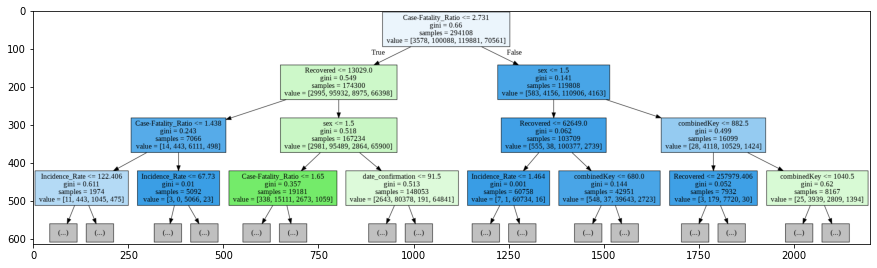

In [ ]:
image = plt.imread('tree.png')
plt.figure(figsize=(15,15))
plt.imshow(image)

**Evaluating Decision Tree**

Adjusting Max Depth

In [ ]:
trainAccuracy = []
validationAccuracy = []
for depth in range(1,30):
  sampledtModel = DecisionTreeClassifier(max_depth = depth, random_state = 10)
  sampledtModel.fit(x_train_encoded, y_train_encoded)
  trainAccuracy.append(sampledtModel.score(x_train_encoded, y_train_encoded))
  validationAccuracy.append(sampledtModel.score(x_validation_encoded, y_validation_encoded))

In [ ]:
df = pd.DataFrame({'maxDepth': range(1,30), 'trainingAccuracy': trainAccuracy, 'validationAccuracy': validationAccuracy})
df.head()

,maxDepth,trainingAccuracy,validationAccuracy
0,1,0.703272,0.704439
1,2,0.722544,0.723167
2,3,0.726386,0.726091
3,4,0.738994,0.739337
4,5,0.766457,0.766130


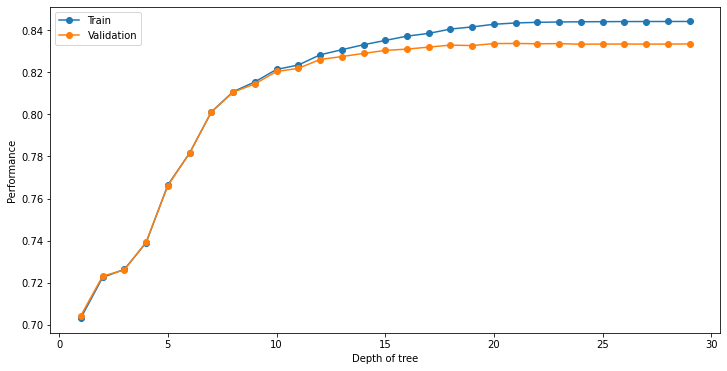

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df['maxDepth'], df['trainingAccuracy'], '-o', label='Train')
plt.plot(df['maxDepth'], df['validationAccuracy'], '-o', label='Validation')
plt.xlabel('Depth of tree')
plt.ylabel('Performance')
plt.legend()
plt.savefig('maxDepthAdjust.png')

In the above graph we can see that the accuracy increases significantly to a max depth of 27 after which it evens out and slowly starts to decrease. Therefore using a max depth of 27 would yield the highest performance

Consfusion Matrix

In [ ]:
print(confusion_matrix(y_validation_encoded, yPred))
print(classification_report(y_validation_encoded, yPred))

[[   77   581    44   219]
 [   39 21922     7  2944]
 [   75    20 29804   220]
 [   53  7830   222  9471]]
              precision    recall  f1-score   support

         0.0       0.32      0.08      0.13       921
         1.0       0.72      0.88      0.79     24912
         2.0       0.99      0.99      0.99     30119
         3.0       0.74      0.54      0.62     17576

    accuracy                           0.83     73528
   macro avg       0.69      0.62      0.63     73528
weighted avg       0.83      0.83      0.82     73528



In [ ]:
accuracy_score(y_validation_encoded, yPred)

0.8333424001740833

Feature importance

In [ ]:
importance = pd.DataFrame({'feature': x_train_encoded.columns, 'importance' : np.round(dtModel.feature_importances_, 3)})
importance.sort_values('importance', ascending=False, inplace = True)
print(importance)

               feature  importance
9  Case-Fatality_Ratio       0.643
2    date_confirmation       0.101
3          combinedKey       0.081
6            Recovered       0.062
1                  sex       0.047
5               Deaths       0.026
8       Incidence_Rate       0.017
0                  age       0.014
7               Active       0.008
4            Confirmed       0.002


GridSearch CV Evaluation

In [ ]:
tuned_parameters = [{'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], 
                     'min_samples_split': [2,4,6,8,10]}]
scores = ['recall']
for score in scores:
    
    print()
    print(f"Tuning hyperparameters for {score}")
    print()
    
    dtModel = GridSearchCV(
        DecisionTreeClassifier(), tuned_parameters,
        scoring = f'{score}_macro'
    )
    dtModel.fit(x_train_encoded, y_train_encoded)
    
    print("Best parameters set found on development set:")
    print()
    print(dtModel.best_params_)
    print()
    print("Grid scores on development set:")
    means = dtModel.cv_results_["mean_test_score"]
    stds = dtModel.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds,
                                 dtModel.cv_results_['params']):
        print(f"{mean:0.3f} (+/-{std*2:0.03f}) for {params}")

**KNN Classifier**

In [ ]:
knnModel = KNeighborsClassifier(n_neighbors = 17)

In [ ]:
knnModel.fit(x_train_encoded, np.ravel(y_train_encoded))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')

In [ ]:
knnpklName = 'knn_classifier.pkl'
knnModelpkl = open(knnpklName, 'wb')
pickle.dump(knnModel, knnModelpkl)
knnModelpkl.close()

In [ ]:
knnModel.score(x_train_encoded, y_train_encoded)

0.824707250397813

In [ ]:
knnModel.score(x_validation_encoded, y_validation_encoded)

0.8229246001523229

In [ ]:
yPredKnn_train = knnModel.predict(x_train_encoded)

In [ ]:
yPredKnn = knnModel.predict(x_validation_encoded)

**Evaluating KNN**

Adjusting Nearest Neighbor

In [ ]:
trainAccuracy = []
validationAccuracy = []
for n_neigh in range(1, 31):
  sampleknnModel = KNeighborsClassifier(n_neighbors = n_neigh)
  sampleknnModel.fit(x_train_encoded, np.ravel(y_train_encoded))
  trainAccuracy.append(sampleknnModel.score(x_train_encoded, y_train_encoded))
  validationAccuracy.append(sampleknnModel.score(x_validation_encoded, y_validation_encoded))

In [ ]:
df = pd.DataFrame({'n_neighbors': range(1,31), 'trainingAccuracy': trainAccuracy, 'validationAccuracy': validationAccuracy})
df.head()

,n_neighbors,trainingAccuracy,validationAccuracy
0,1,0.794082,0.784626
1,2,0.790798,0.784721
2,3,0.802794,0.799083
3,4,0.810553,0.806781
4,5,0.809964,0.806455


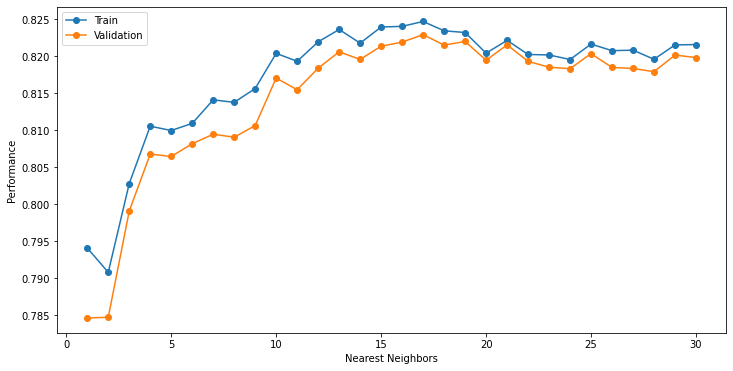

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df['n_neighbors'], df['trainingAccuracy'], '-o', label='Train')
plt.plot(df['n_neighbors'], df['validationAccuracy'], '-o', label='Validation')
plt.xlabel('Nearest Neighbors')
plt.ylabel('Performance')
plt.legend()

Confusion Matrix

In [ ]:
print(confusion_matrix(y_train_encoded, yPredKnn_train))
print(classification_report(y_train_encoded, yPredKnn_train))

[[   156   2148    322    952]
 [    14  84233    122  15719]
 [    41     60 119026    754]
 [    39  30100   1284  39138]]
              precision    recall  f1-score   support

         0.0       0.62      0.04      0.08      3578
         1.0       0.72      0.84      0.78    100088
         2.0       0.99      0.99      0.99    119881
         3.0       0.69      0.55      0.62     70561

    accuracy                           0.82    294108
   macro avg       0.76      0.61      0.62    294108
weighted avg       0.82      0.82      0.82    294108



In [ ]:
print("Accuracy Train {0:.2f}%".format(100*accuracy_score(y_train_encoded, yPredKnn_train)))

Accuracy Train 82.47%


In [ ]:
print(confusion_matrix(y_validation_encoded, yPredKnn))
print(classification_report(y_validation_encoded, yPredKnn))

[[   31   561    79   250]
 [    4 21012    26  3870]
 [   13    25 29836   245]
 [   12  7585   350  9629]]
              precision    recall  f1-score   support

         0.0       0.52      0.03      0.06       921
         1.0       0.72      0.84      0.78     24912
         2.0       0.98      0.99      0.99     30119
         3.0       0.69      0.55      0.61     17576

    accuracy                           0.82     73528
   macro avg       0.73      0.60      0.61     73528
weighted avg       0.82      0.82      0.81     73528



In [ ]:
print("Accuracy Validation {0:.2f}%".format(100*accuracy_score(y_validation_encoded, yPredKnn)))

Accuracy Validation 82.29%
